## TASK

Обучите нейронную сеть любой архитектуры на каком-то производственном датасете. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.  
В конце, обязательно подвести вывод.


# Обучение

 ## Установка библеотек

In [29]:
#!pip install tensorflow
#!pip install tensorflow_datasets
#!pip install numpy
#!pip install matplotlib 

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


## Подготовка данных

In [6]:
# Загрузка набора данных цветов
def load_flower_dataset(image_size, batch_size):
    dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True, shuffle_files=True)
    train_dataset = dataset['train']

    def preprocess_image(image, label):
        image = tf.image.resize(image, [image_size, image_size])
        image = (image - 127.5) / 127.5  # Нормализация
        return image

    train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)
    return train_dataset

image_size = 64
batch_size = 64
train_dataset = load_flower_dataset(image_size, batch_size)


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|                                                                         | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.09 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                                                      | 0/344862509 [00:00<?, ? MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████| 344862509/344862509 [00:00<00:00, 23177819811.06 MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████| 344862509/344862509 [00:00<00:00, 23177819811.06 MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████| 344862509/344862509 [00:00<00:00, 11300189846.71 MiB/s]

Dl Size...: 100%|█████████████████████████████████████████████▉| 344862509/344863011 [00:00<00:00, 8777318492.36 MiB/s]

Dl Size

Dataset oxford_flowers102 downloaded and prepared to C:\Users\User\tensorflow_datasets\oxford_flowers102\2.1.1. Subsequent calls will reuse this data.


## Генератор

In [11]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model
    
generator = make_generator_model()

## Дискрименатор

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[image_size, image_size, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

## Определение функции потерь и оптимизаторов

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


## Обучение

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
    generate_and_save_images(generator, epochs, seed)


## Функция генерации и сохранения изображений

In [17]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    predictions = (predictions + 1) / 2.0  
    
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        img = predictions[i].numpy() 
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()



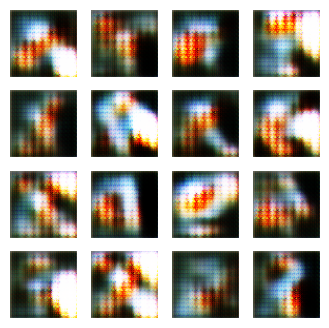

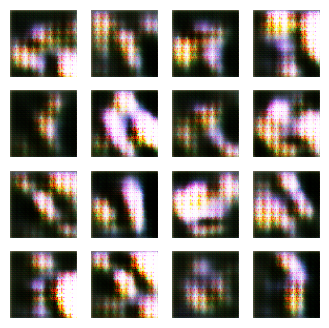

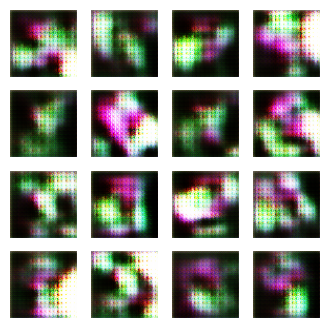

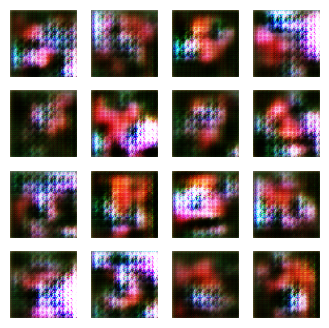

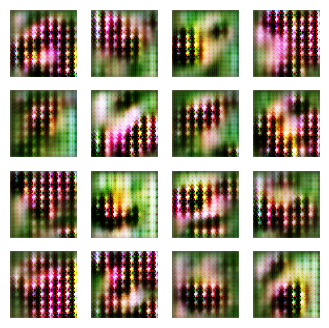

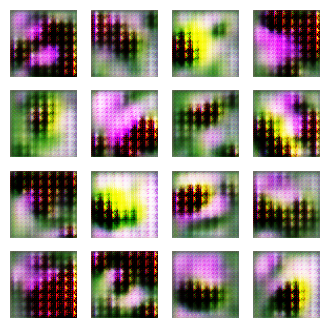

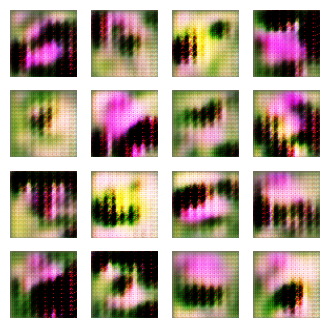

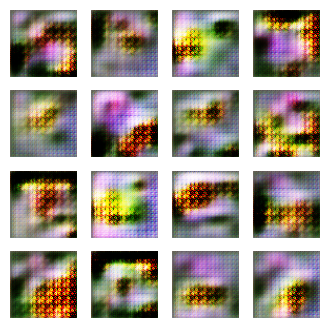

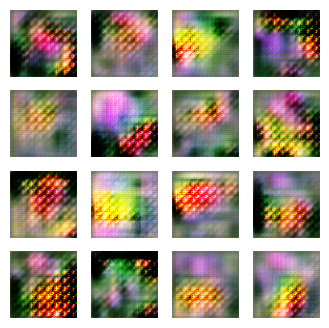

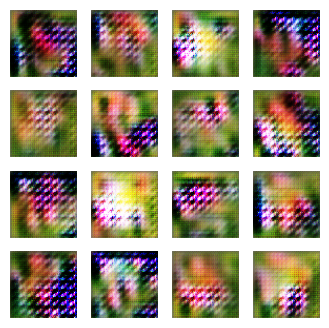

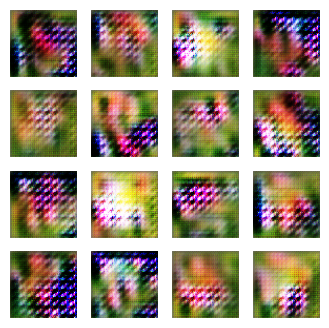

In [27]:
EPOCHS = 100
train(train_dataset, EPOCHS)


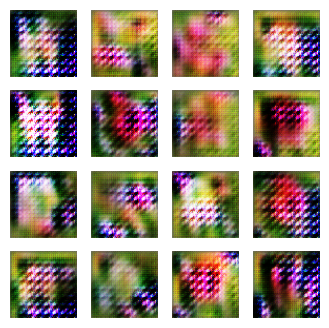

In [28]:
# Генерация изображений после завершения тренировки
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Генерация изображений
generated_images = generator(seed, training=False)

# Отображение и сохранение изображений
generate_and_save_images(generator, EPOCHS, seed)

# Вывод

На данном примере я увидел как обучаются и работает, генеративная состязательная сеть (GAN).   
Мне удалось улучшить результат генерации, увеличив количество эпох (хотя бы до 100), при обучении НС.   
Модель нейронной сети построена на TensorFlow.¶